# Prediction model of intersection safety
by: James Hatch

---

#Motivation and Context:

Neural networks are used in many fields to predict a lot of different events. While data comes in all shapes in sizes, more and more location-based data is becomming accessible to the public through platforms such as Open Street Maps (OSM), ArcGIS, Google Maps, and more.

That being said, predictive models are also prone to accumulate biases from their training data. This has led to the creation of models that, while displaying high categorical accuracy, are prone to making biased predictions in response to data. Since models are now being heavily incorporated into highly consequential fields such as incarceration and security, analyzing models for bias has become just as important as analyzing model accuracy.

Each year, thousands of people are killed in fatal car accidents. While accident-predicting models have the potential to save a lot of lives, biases in these models have the potential to reveal even deeper socioeconomic patterns (such as road maintenance and management relative to regional government funding differences). Ultimately, identifying and addressing these patterns might allow us to tackle the more systemic issues that are connected to fatal car crashes.

---

#Model Overview:

I intend to create a multimodal model that identifies fatal crash hotspots in U.S. cities using static street map images (collected using google static street view and fed into a CNN) and weather features (fed into an ANN). This model will be trained and tested using street intersection data collected using OSM (open street maps) and fatal car crash data provided by the FARS dataset.

In order to examine the development of biases in the trained model, I plan on using this model to predict the most common accident hotspots in Chicago. While having a high number of fatal car crashes each year, Chicago is a city know for having significant wealth disparities in different areas of the city. Since factors such as wealth may influence crash-related variables such as road maintenance, I hope to examine the model's predictions for patterns involving the most accident-prone areas in the city.

_Note: I was not able to make it to a full Chicago-level analysis this semester due to google API cost issues, but I will be able to run these tests next semester. Additionally, experimentation revealed that weather data is incompatible with my current model setup. As a result, I plan to use street features in my ANN instead._

##Target City
- Chicago (testing city - high population density)

---

##Predictive data
Street Imagery (CNN)
- Static street view google API
- OSM

Additional data
- Census data (estimated population sizes)

---

##Ground truth data
- FARs (fatal car accidents data)


Notes for the data:
- All data must come from 2015-2019 (inclusive) as 2020-2021 was COVID years and 2022-onward has corrupted pathways on the FARS dataset.


In [ ]:
# imports
import tensorflow as tf
import keras
import keras_hub
import numpy as np
import pandas as pd
import matplotlib as plt
import duckdb
import os
import re
from plotnine import *
import sklearn
import geopandas as gpd

## Cloning the Github Repository

In [ ]:
# clones the github repository for use in google colab notebooks
from google.colab import userdata
accessToken = userdata.get('IntersectionToken')

# accesses the github dataset by cloning the repository and downloading its contents
repo_url = f"https://{accessToken}@github.com/SleepDeprived3/Intersection_Safety_Prediction.git"
!git clone {repo_url}

Cloning into 'Intersection_Safety_Prediction'...
remote: Enumerating objects: 87, done.
remote: Counting objects: 100% (87/87), done.
remote: Compressing objects: 100% (77/77), done.
remote: Total 87 (delta 21), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (87/87), 18.34 MiB | 3.87 MiB/s, done.
Resolving deltas: 100% (21/21), done.


##Step 1 - Preliminary Analysis

I will start by acquiring data from the FARS (fatality analysis reporting system) dataset, a U.S. dataset containing information about fatal injuries from car crashes.

In [ ]:
# Chosen since street map images seem to be low in quality prior to 2015
min_year_of_data = 2015

# Chosen since some of the FARS data is corrupted between 2021-2023. Also, 2020-2021 was COVID-era
# which might skew results
max_year_of_data = 2018

list_of_years = range(min_year_of_data,max_year_of_data + 1)

In [ ]:
# Used to retrieve all data from the FARS dataset
for year in list_of_years:
  print(year)
  !wget https://static.nhtsa.gov/nhtsa/downloads/FARS/{year}/National/FARS{year}NationalCSV.zip
  !unzip FARS{year}NationalCSV.zip -d fars{year}

# FARS dataset guide: https://crashstats.nhtsa.dot.gov/Api/Public/ViewPublication/813706

2015
--2025-12-15 22:20:17--  https://static.nhtsa.gov/nhtsa/downloads/FARS/2015/National/FARS2015NationalCSV.zip
Resolving static.nhtsa.gov (static.nhtsa.gov)... 23.12.4.159, 2600:1407:7400:b89::27ea, 2600:1407:7400:b94::27ea
Connecting to static.nhtsa.gov (static.nhtsa.gov)|23.12.4.159|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29908134 (29M) [application/x-zip-compressed]
Saving to: ‘FARS2015NationalCSV.zip’

FARS2015NationalCSV 100%[===================>]  28.52M  60.5MB/s    in 0.5s    

2025-12-15 22:20:18 (60.5 MB/s) - ‘FARS2015NationalCSV.zip’ saved [29908134/29908134]

Archive:  FARS2015NationalCSV.zip
  inflating: fars2015/FARS2015NationalCSV/accident.csv  
  inflating: fars2015/FARS2015NationalCSV/cevent.csv  
  inflating: fars2015/FARS2015NationalCSV/Damage.csv  
  inflating: fars2015/FARS2015NationalCSV/Distract.csv  
  inflating: fars2015/FARS2015NationalCSV/DrImpair.csv  
  inflating: fars2015/FARS2015NationalCSV/Factor.csv  
  inflating: fa

In [ ]:
FARS_df_list = []

for year in list_of_years:
  # creating the path
  if year == 2015:
    yearPath = "/content/fars2015/FARS2015NationalCSV/accident.csv" # extra folder and lowercase csv letters made this an edge case
  elif year == 2018:
    yearPath = "/content/fars2018/accident.csv" # lowercase csv letters made this an edge case
  else: yearPath = f"/content/fars{year}/accident.CSV"

  # checking if the path exists, prints the path if not, creates a dataframe if it does exist
  if not os.path.exists(yearPath):
        print(f"Missing {year} path")
  else:
    year_df = duckdb.query(f"""
          SELECT
              ST_CASE, -- id used to match collision data from different CSVs
              STATENAME, -- Name of the state where the collision happened
              COUNTY,    -- GSA geographical code of the county where the collision happened
              CITY,      -- GSA geographical code of the city where the collision happened
              TYP_INT,   -- the type of intersection encountered (number id)
              MONTH, -- month of the collision
              DAY,   -- day of the collision
              YEAR,  -- year of the collision
              HOUR,  -- hour of the collision
              LATITUDE,    -- latitude coordinate of the collision  (to the seventh decimal point)
              LONGITUD,    -- longitude coordinate of the collision  (to the seventh decimal point)
              WEATHER,  -- the type of atmospheric conditions during the crash (number id)
              LGT_COND  -- the type and level of light during the crash (number id)
          FROM read_csv_auto('{yearPath}')
      """).df()
    FARS_df_list.append(year_df)

combined_FARS_df = pd.concat(FARS_df_list)

In [ ]:
combined_FARS_df.head()

,ST_CASE,STATENAME,COUNTY,CITY,TYP_INT,MONTH,DAY,YEAR,HOUR,LATITUDE,LONGITUD,WEATHER,LGT_COND
0,10001,Alabama,127,0,1,1,1,2015,2,33.878653,-87.325328,1,2
1,10002,Alabama,83,0,1,1,1,2015,22,34.910442,-86.908708,10,2
2,10003,Alabama,11,0,1,1,1,2015,1,32.142006,-85.758456,1,2
3,10004,Alabama,45,0,1,1,4,2015,0,31.439814,-85.510300,10,2
4,10005,Alabama,45,2050,3,1,7,2015,7,31.319331,-85.515100,1,1


In [ ]:
# filters non-city IDs out of the FARS data
combined_FARS_with_citynames_df = combined_FARS_df[~combined_FARS_df['CITY'].isin([0, 9997, 9898, 9999])]

# creates a dataframe that shows the cities with the greatest total number of fatal accidents
most_common_accident_locations = combined_FARS_with_citynames_df.groupby(['CITY', 'STATENAME']).size().reset_index(name='Count').sort_values(by='Count', ascending=False)
most_common_accident_locations.head(10)

,CITY,STATENAME,Count
4989,1980,California,1091
7081,3280,Texas,864
1255,370,Arizona,848
7977,4170,New York,847
4479,1730,Texas,703
9243,6090,Texas,615
4025,1510,Florida,523
4346,1670,Illinois,488
3487,1260,Michigan,422
4259,1620,Tennessee,415


In [ ]:
# USED TO FIND CITY BY CODE AND LOCATION BY FOUND CITY LAT/LONG
#combined_FARS_df[combined_FARS_df['CITY'] == ____]

Examining the longitude and latitutde coordinates of the most common accident cities gets you the following cities (in order ranked by total number of car crashes):

1. Los Angeles, CA (1091 fatalities)
2. Houston, TX (864 fatalities)
3. Phoenix, AZ (848 fatalities)
4. New York, NY (847 fatalities)
5. Dallas, TX (703 fatalities)
6. San Antonio, TX (615 fatalities)
7. Jacksonville, FL (523 fatalities)
8. Chicago, IL (488 fatalities)
9. Detroit, MI (422 fatalities)
10. Memphis, TN (415 fatalities)




In [ ]:
# importing pep census predictions (https://www.census.gov/programs-surveys/popest/technical-documentation/research/evaluation-estimates/2020-evaluation-estimates/2010s-cities-and-towns-total.html)
!wget https://www2.census.gov/programs-surveys/popest/datasets/2010-2020/cities/SUB-EST2020_ALL.csv

--2025-12-15 22:20:31--  https://www2.census.gov/programs-surveys/popest/datasets/2010-2020/cities/SUB-EST2020_ALL.csv
Resolving www2.census.gov (www2.census.gov)... 172.65.90.26, 172.65.90.25, 172.65.90.24, ...
Connecting to www2.census.gov (www2.census.gov)|172.65.90.26|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10185581 (9.7M) [text/csv]
Saving to: ‘SUB-EST2020_ALL.csv’

SUB-EST2020_ALL.csv 100%[===================>]   9.71M  46.8MB/s    in 0.2s    

2025-12-15 22:20:31 (46.8 MB/s) - ‘SUB-EST2020_ALL.csv’ saved [10185581/10185581]



In [ ]:
# forms a pandas dataframe using the excel spreadsheet
population_estimates = pd.read_csv('/content/SUB-EST2020_ALL.csv', encoding="latin1", dtype={"STATE": str,"PLACE": str})
population_estimates_copy = population_estimates.copy()

# create two lists of strings containing the values of the relevant columns
list_of_years_str = []
for year in list(list_of_years):
  list_of_years_str.append("POPESTIMATE" + str(year))
relevant_columns = ["NAME", "STNAME", "STATE", "PLACE"] + list_of_years_str

# drop all rows with NA values
relevant_pop_estimates = population_estimates_copy[relevant_columns].dropna()

# find the mean estimated population of the provided population columns
relevant_pop_estimates["GEOID"] = relevant_pop_estimates["STATE"].str.zfill(2) + relevant_pop_estimates["PLACE"].str.zfill(5)
relevant_pop_estimates["mean_population"] = relevant_pop_estimates[list_of_years_str].mean(axis=1)


high_fatality_cities = ["Los Angeles city", "Houston city", "Phoenix city", "New York city", "Dallas city", "San Antonio city", "Jacksonville city", "Chicago city", "Detroit city", "Memphis city"]
high_fatality_cities_states = ["California", "Texas", "Arizona", "New York", "Texas", "Texas", "Florida", "Illinois", "Michigan", "Tennessee"]


relevant_pop_estimates[relevant_pop_estimates['NAME'].isin(high_fatality_cities) & relevant_pop_estimates['STNAME'].isin(high_fatality_cities_states)]

,NAME,STNAME,STATE,PLACE,POPESTIMATE2015,POPESTIMATE2016,POPESTIMATE2017,POPESTIMATE2018,GEOID,mean_population
1514,Phoenix city,Arizona,04,55000,1583760,1612303,1633704,1655082,0455000,1621212.25
1612,Phoenix city,Arizona,04,55000,1583760,1612303,1633704,1655082,0455000,1621212.25
3094,Los Angeles city,California,06,44000,3933644,3957520,3975067,3981140,0644000,3961842.75
3519,Los Angeles city,California,06,44000,3933644,3957520,3975067,3981140,0644000,3961842.75
5209,Jacksonville city,Florida,12,35000,866345,881502,893203,904170,1235000,886305.00
5380,San Antonio city,Florida,12,63375,1289,1336,1409,1447,1263375,1370.25
5567,Jacksonville city,Florida,12,35000,866345,881502,893203,904170,1235000,886305.00
5860,San Antonio city,Florida,12,63375,1289,1336,1409,1447,1263375,1370.25
8175,Chicago city,Illinois,17,14000,2724006,2716297,2710456,2700968,1714000,2712931.75
8526,Jacksonville city,Illinois,17,38115,18980,19103,18907,18789,1738115,18944.75


In [ ]:
# Copying information from the most_common_accident_locations dataframe
high_fatality_cities = ["Los Angeles city", "Houston city", "Phoenix city", "New York city", "Dallas city", "San Antonio city", "Jacksonville city", "Chicago city", "Detroit city", "Memphis city"]
high_fatality_cities_states = ["California", "Texas", "Arizona", "New York", "Texas", "Texas", "Florida", "Illinois", "Michigan", "Tenessee"]
fatalities_count = [1091,864,848,847,703,615,523,488,422,415]

# Calculates relative fatal incident percentages using estimated population means
# collected across the target years (and displayed in relevant_pop_estimates)
LA_percent = 1091 / 3961842.75
Houston_percent = 864 / 2304383.25
Pheonix_percent = 848 / 1621212.25
NYC_percent = 847 / 8441605.00
Dallas_percent = 703 / 1327103.25
San_Antonio_percent = 615 / 1498933.50
Jacksonville_percent = 523 / 886305.00
Chicago_percent = 488 / 2712931.75
Detroit_percent = 422 / 676407.50
Memphis_percent = 415 / 652648.25

# Adds relative fatalities to the previous lists to form a dataframe
relative_fatalities = [LA_percent, Houston_percent, Pheonix_percent, NYC_percent, Dallas_percent, San_Antonio_percent, Jacksonville_percent, Chicago_percent, Detroit_percent, Memphis_percent]

relative_fatalities_df = {
    "city" : high_fatality_cities,
    "state" : high_fatality_cities_states,
    "fatalities" : fatalities_count,
    "relative fatalities" : relative_fatalities
}

# Sorts the dataframe by relative fatalities to see which of the top ten cities
# for total fatal accident counts have the highest values relative to their
# population
relative_fatalities_df = pd.DataFrame(relative_fatalities_df)
relative_fatalities_df.sort_values(by="relative fatalities", ascending=False)

,city,state,fatalities,relative fatalities
9,Memphis city,Tenessee,415,0.000636
8,Detroit city,Michigan,422,0.000624
6,Jacksonville city,Florida,523,0.000590
4,Dallas city,Texas,703,0.000530
2,Phoenix city,Arizona,848,0.000523
5,San Antonio city,Texas,615,0.000410
1,Houston city,Texas,864,0.000375
0,Los Angeles city,California,1091,0.000275
7,Chicago city,Illinois,488,0.000180
3,New York city,New York,847,0.000100


In order to collect a diverse range of photos for our dataset, I plan to use intersections from three cities in the list of the top ten cities with the most (total) fatal accidents (shown above). In order to choose these cities, I decided to use the following reasoning:

1. ***Memphis*** - the city in the top ten list with the most fatal crashes relative to its average estimated population size during the FARS dataset years range
2. ***New York City*** - the city in the top ten list with the least fatal crashes relative to its average estimated population size during the FARS dataset years range
3. ***Los Angeles*** - the city in the top ten list with the most a good mixture of road geometries for validation testing

Finally, when applying this model, I plan to use ***Chicago*** as my testing data location due to high wealth differences in its different counties.

The following section will be used to collect street view image data from the training datasets in order to allow for the creation of a accident hotspot model.

---
## Step 2 - Finding Intersections and Crash Location

In [ ]:
# installing programs that use Open Street Maps to create map networks
%pip install osmnx
import osmnx as ox
import networkx as nx
# for me: https://osmnx.readthedocs.io/en/stable/user-reference.html
# for me: https://networkx.org/documentation/stable/tutorial.html

def findIntersections(city):
  # retrieves a node graph from the cities of interest and identifies nodes
  # that mark intersections. also attempts to filter for non-standard
  # road intersections such as highway entrances, service roads, etc.
  G = ox.graph_from_place(city, network_type="drive")
  G = ox.project_graph(G)
  # prevent multi-node intersections from being counted twice by adding 15 meters of
  # overlapping node tolerance
  G = ox.consolidate_intersections(
    G,
    tolerance=15,
    rebuild_graph=True,
    dead_ends=False
  )
  Gu = ox.convert.to_undirected(G)
  intersection_nodes = [n for n, d in Gu.degree() if d >= 3]

  # creates a list of dictionaries for each intersection node that contains the
  # intersection id, x, and y
  intersections = []
  for node in intersection_nodes:
    data = G.nodes[node]
    intersections.append({
      "id": node,
      "x": data["x"],
      "y": data["y"]
    })

  # Creates a geodataframe containing the x and y info as well as the coordinate
  # reference system so the x and y coordinates can later be decoded into latitude
  # and longitude
  geodf = gpd.GeoDataFrame(
    intersections,
    geometry=gpd.points_from_xy(
        [r["x"] for r in intersections],
        [r["y"] for r in intersections]
    ),
    crs=G.graph["crs"]
  )

  # Use the Geodataframe to find longitude and latitude
  geodf_long_lat = geodf.to_crs("EPSG:4326")
  geodf["longitude"] = geodf_long_lat.geometry.x
  geodf["latitude"]  = geodf_long_lat.geometry.y

  return pd.DataFrame(geodf.drop(columns="geometry"))

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.5/101.5 kB 4.1 MB/s eta 0:00:00


In [ ]:
# Forming a list of cities for OSM to look up intersections for. This list contains the three (intended)
# training cities (New York City, Memphis, and Los Angeles), and one testing city (Chicago)
cities_of_interest = [{"city": "New York City", "state": "New York", "country": "United States"},
                      {"city": "Memphis", "state": "Tennessee", "country": "United States"},
                      {"city": "Los Angeles", "state": "California", "country": "United States"},
                      {"city": "Chicago", "state": "Illinois", "country": "United States"}]

In [ ]:
# Loading each of the intersection geodataframes using my previously defined method
# Doing this in individual cells to allow each one to be saved one at a time.
NYC_intersections = findIntersections(cities_of_interest[0])

In [ ]:
MEM_intersections = findIntersections(cities_of_interest[1])

In [ ]:
LA_intersections = findIntersections(cities_of_interest[2])

In [ ]:
CHI_intersections = findIntersections(cities_of_interest[3])

In [ ]:
# Cell that creates subdataframes for each of the target cities in the FARS dataframe
NYC_FARS = combined_FARS_df[(combined_FARS_df['CITY'] == 4170) & (combined_FARS_df['STATENAME'] == "New York")]
MEM_FARS = combined_FARS_df[(combined_FARS_df['CITY'] == 1620) & (combined_FARS_df['STATENAME'] == "Tennessee")]
LA_FARS = combined_FARS_df[(combined_FARS_df['CITY'] == 1980) & (combined_FARS_df['STATENAME'] == "California")]
CHI_FARS = combined_FARS_df[(combined_FARS_df['CITY'] == 1670) & (combined_FARS_df['STATENAME'] == "Illinois")]

In [ ]:
# checking the number of crashes and number of intersections in memphis
print("Total number of intersections in memphis = " + str(MEM_intersections.size))
print("Total number of fatal accidents in memphis across all tested years = " + str(MEM_FARS.size))

Total number of intersections in memphis = 68185
Total number of fatal accidents in memphis across all tested years = 5395


##IMPORTANT NOTE:
The google static street view API costs money when scraping over 10,000 images. As you can see from the above information, retrieving images from every crash site and intersection in every city would be too much for the scope of this project. As a result, we will be creating a smaller model using only one city for the time being.

In [ ]:
# Used to reduce the number of FARS samples and conserve street view API images.
# 2015 in particular was chosen for the possibility of predicting accidents in
# future years with the later FARS data. To be deleted later upon gaining more
# API credits.
NYC_FARS = NYC_FARS[NYC_FARS['YEAR'] == 2015]
MEM_FARS = MEM_FARS[MEM_FARS['YEAR'] == 2015]
LA_FARS = LA_FARS[LA_FARS['YEAR'] == 2015]
CHI_FARS = CHI_FARS[CHI_FARS['YEAR'] == 2015]

In [ ]:
# imports tools for creating GeoDataFrames, which will help convert longitude and latitude
# coordinates into meters
import geopandas as gpd
from shapely.geometry import Point
from sklearn.neighbors import BallTree


# A function that matches FARS intersections with the intersection df.
# Returns an edited list of the intersections which includes the number of crashes that
# occur at that intersection. Also takes in the coordinate reference system of the
# target city's time zone as input.
def match_intersections(intersection_df, FARS_subframe, crs_input):
  # Distance limit between coordinates in meters
  max_dist = 30

  FARS_subframe = FARS_subframe[
    (FARS_subframe["LATITUDE"].between(-90, 90)) &
    (FARS_subframe["LONGITUD"].between(-180, 180))
  ].copy()

  # Setting up the return dataframe with 0 values for the number of accidents
  return_intersections = intersection_df.copy()
  return_intersections["numberFatalAccidents"] = 0

  # Create geodataframes for the FARS and intersection datasets for intersection matching
  geoIntersection = gpd.GeoDataFrame(
    intersection_df,
    geometry=gpd.points_from_xy(
        intersection_df["x"],
        intersection_df["y"]
    ),
    crs=crs_input
  )

  geoFARS = gpd.GeoDataFrame(
    FARS_subframe,
    geometry=gpd.points_from_xy(FARS_subframe["LONGITUD"], FARS_subframe["LATITUDE"]),
    crs="EPSG:4326"
  )

  # Convert longitude and latitude to meters by converting the FARS geodataframes into Intersection coordinate reference system
  FARS_meters = geoFARS.to_crs(geoIntersection.crs)

  # Takes X and Y coordinates from the converted coordinate reference systems
  FARS_meters["x"] = FARS_meters.geometry.x
  FARS_meters["y"] = FARS_meters.geometry.y

  # Used to find nearest K-neighbors to the intersections
  intersectionTree = BallTree(np.column_stack([geoIntersection.geometry.x, geoIntersection.geometry.y]), metric="euclidean")

  # Queries the intersection tree to provide relative location information for the crash data
  distance, index = intersectionTree.query(np.column_stack([FARS_meters.x, FARS_meters.y]), k=1)

  # Finds the closest intersection to a crash
  valid = distance[:, 0] <= max_dist
  matched_intersections = index[valid, 0]

  # Adds the matched intersection to the subframe
  for index in matched_intersections:
    return_intersections.iloc[index, return_intersections.columns.get_loc("numberFatalAccidents")] = return_intersections.iloc[index, return_intersections.columns.get_loc("numberFatalAccidents")] + 1

  return return_intersections

In [ ]:
import math

# Finds the ESPG value for a given city based on it's longitude value.
# Used to turn longitude and latitude coordinates into meter-based coordinates
# since the curvature of the earth prevents a fully-accurate coordinate system
# for the whole world (and because we have to calculate EVERYTHING)
def findESPGValue(FARS_subframe):
  longitude = FARS_subframe['LONGITUD'].iloc[0]
  EPSG = "EPSG:326" + str(math.floor((longitude + 180) / 6) + 1)
  return(EPSG)

In [ ]:
# creates a dataframe for each FAR/intersection pair that contains counts of the
# number of fatal accidents in each intersection and the coordinates of the intersection

# mmatch_intersections(NYC_intersections, NYC_FARS, findESPGValue(NYC_FARS)).groupby(['numberFatalAccidents']).count()
xyNYC = match_intersections(NYC_intersections, NYC_FARS, findESPGValue(NYC_FARS))

In [ ]:
xyMEM = match_intersections(MEM_intersections, MEM_FARS, findESPGValue(MEM_FARS))

In [ ]:
xyLA = match_intersections(LA_intersections, LA_FARS, findESPGValue(LA_FARS))

In [ ]:
xyCHI = match_intersections(CHI_intersections, CHI_FARS, findESPGValue(CHI_FARS))

## Step 3 - Collecting Static Street View Images

In [ ]:
from pyproj import Transformer

# A function that returns a dataframe containing approach view
# information for a given intersection
def find_approach_views(G, intersections_df):
  return_views = []

  # Explicitly construct a GeoDataFrame of road segments, ensuring 'u' and 'v' columns are present
  edges_list = []
  for u, v, key, data in G.edges(data=True, keys=True):
      if 'geometry' in data:
          edges_list.append({
              'u': u,
              'v': v,
              'key': key,
              'geometry': data['geometry'],
              **{k: v for k, v in data.items() if k not in ['u', 'v', 'key', 'geometry']}
          })
  edges_gdf = gpd.GeoDataFrame(edges_list, crs=G.graph["crs"])

  # Sets new variables equal to variables in the intersections dataframe
  for _, row in intersections_df.iterrows():
    node = row["id"]
    lat  = row["latitude"]
    lon  = row["longitude"]
    label = row["numberFatalAccidents"]

    # identifies approach road segments using starting and ending nodes
    inc_edges = edges_gdf[(edges_gdf["u"] == node) | (edges_gdf["v"] == node)]

    # identifies a angle of attack for each road segment edge
    for _, edge in inc_edges.iterrows():

      # Get projected coordinates of the far and near points
      if edge["u"] == node: # edge goes from u node to v node
        p_far_projection = edge.geometry.coords[1]
        p_near_projection = edge.geometry.coords[0]
      else: # edge goes v node to u node
        p_far_projection = edge.geometry.coords[-2]
        p_near_projection = edge.geometry.coords[-1]

      # Calculate angle from the far point to the near point (towards the intersection)
      dx = p_near_projection[0] - p_far_projection[0]
      dy = p_near_projection[1] - p_far_projection[1]
      angle = (math.degrees(math.atan2(dx, dy)) + 360) % 360

      # defines the camera position (latitude and longitude) by moving the camera 15 meters opposite the
      # desired approach angle
      radian = math.radians(angle)
      dx = -15 * math.sin(radian)
      dy = -15 * math.cos(radian)
      camera_x = p_near_projection[0] + dx
      camera_y = p_near_projection[1] + dy

      transformer = Transformer.from_crs(G.graph["crs"], "EPSG:4326", always_xy=True)
      camera_lon, camera_lat = transformer.transform(camera_x, camera_y)

      # Appends the appropriate information to the return_views list
      return_views.append({
          "intersection_id": node,
          "lat": camera_lat,
          "lon": camera_lon,
          "heading": angle,
          "label": label
      })

  return pd.DataFrame(return_views)

In [ ]:
def findG(city):
  # retrieves a node graph from the cities of interest and identifies nodes
  # that mark intersections. also attempts to filter for non-standard
  # road intersections such as highway entrances, service roads, etc.
  G = ox.graph_from_place(city, network_type="drive")
  G = ox.project_graph(G)
  # prevent multi-node intersections from being counted twice by adding 15 meters of
  # overlapping node tolerance
  G = ox.consolidate_intersections(
    G,
    tolerance=15,
    rebuild_graph=True,
    dead_ends=False
  )
  return G

In [ ]:
NYC_G = findG(cities_of_interest[0])
MEM_G = findG(cities_of_interest[1])
LA_G = findG(cities_of_interest[2])
CHI_G = findG(cities_of_interest[3])

In [ ]:
NYC_approach = find_approach_views(NYC_G, xyNYC).drop_duplicates()

In [ ]:
MEM_approach = find_approach_views(MEM_G, xyMEM).drop_duplicates()

In [ ]:
LA_approach = find_approach_views(LA_G, xyLA).drop_duplicates()

In [ ]:
CHI_approach = find_approach_views(CHI_G, xyCHI).drop_duplicates()

In [ ]:
# a function used to get street view pathways for each city given the provided dataframe
# which contains heading, longitude, and latitude
streetViewToken = userdata.get('StreetViewProject')

def getStreetViews(approach_df):
  approach_df_new = approach_df.copy()

  for index, row in approach_df_new.iterrows():
    string_no_sig = ("https://maps.googleapis.com/maps/api/streetview?size=400x400&location=" +
    str(row['lat']) + "," + str(row['lon']) + "&heading=" +
    str(row['heading']) + "&key=" + streetViewToken)

    full_string = sign_url(string_no_sig)
    approach_df_new.loc[index, 'path'] = full_string
  return approach_df_new

In [ ]:
# Used to decode street view api signatures. Taken entirely from Google API dev
# guide (https://developers.google.com/maps/documentation/streetview/digital-signature#generate-signed-request)

#!/usr/bin/python
# -*- coding: utf-8 -*-
""" Signs a URL using a URL signing secret """

import hashlib
import hmac
import base64
import urllib.parse as urlparse


def sign_url(input_url=None, secret="wc-C8Kljh7dvUwlQZDLXu1yLS50="):
    """ Sign a request URL with a URL signing secret.
      Usage:
      from urlsigner import sign_url
      signed_url = sign_url(input_url=my_url, secret=SECRET)
      Args:
      input_url - The URL to sign
      secret    - Your URL signing secret
      Returns:
      The signed request URL
  """

    if not input_url or not secret:
        raise Exception("Both input_url and secret are required")

    url = urlparse.urlparse(input_url)

    # We only need to sign the path+query part of the string
    url_to_sign = url.path + "?" + url.query

    # Decode the private key into its binary format
    # We need to decode the URL-encoded private key
    decoded_key = base64.urlsafe_b64decode(secret)

    # Create a signature using the private key and the URL-encoded
    # string using HMAC SHA1. This signature will be binary.
    signature = hmac.new(decoded_key, str.encode(url_to_sign), hashlib.sha1)

    # Encode the binary signature into base64 for use within a URL
    encoded_signature = base64.urlsafe_b64encode(signature.digest())

    original_url = url.scheme + "://" + url.netloc + url.path + "?" + url.query

    # Return signed URL
    return original_url + "&signature=" + encoded_signature.decode()


In [ ]:
# Gets the street view paths for each city
NYC_with_path = getStreetViews(NYC_approach)
MEM_with_path = getStreetViews(MEM_approach)
LA_with_path = getStreetViews(LA_approach)
CHI_with_path = getStreetViews(CHI_approach)

In [ ]:
# Checking the number of images for each path
print(NYC_with_path.size)
print(MEM_with_path.size)
print(LA_with_path.size)
print(CHI_with_path.size)

838608
256368
613452
478920


In [ ]:
# Function that significantly reduces the number of samples for each city by
# reducing the amount of data for nonfatal intersections to show significantly
# less images per intersection
def reduceSamples(city_with_path, noncrash_intersections=1):

  reduced_list = []

  for intersection_id, group in city_with_path.groupby('intersection_id'):
    fatality = group[group['label'] == True]
    non_fatality = group[group['label'] == False]

    # Keep all crashes
    df_reduced = [fatality]

    # Randomly sample non-crashes up to max_non_crash_per_intersection
    if len(non_fatality) > 0:
      sampled_non_crash = non_fatality.sample(
        n=min(len(non_fatality), noncrash_intersections),
        random_state=42)

      df_reduced.append(sampled_non_crash)

    reduced_list.append(pd.concat(df_reduced))

  # Concatenate all intersections
  df_reduced = pd.concat(reduced_list).reset_index(drop=True)
  return df_reduced

In [ ]:
# uses the previously defined function to significantly reduce the number of samples
NYC_reduced = reduceSamples(NYC_with_path)
MEM_reduced = reduceSamples(MEM_with_path)
LA_reduced = reduceSamples(LA_with_path)
CHI_reduced = reduceSamples(CHI_with_path)

In [ ]:
MEM_reduced.head()

,intersection_id,lat,lon,heading,label,path
0,3.0,35.126430,-89.774228,6.846266,0.0,https://maps.googleapis.com/maps/api/streetvie...
1,4.0,35.127717,-89.776129,278.109148,0.0,https://maps.googleapis.com/maps/api/streetvie...
2,5.0,35.169416,-89.915529,273.401767,0.0,https://maps.googleapis.com/maps/api/streetvie...
3,6.0,35.169379,-89.914035,93.401767,0.0,https://maps.googleapis.com/maps/api/streetvie...
4,7.0,35.170403,-89.915811,94.467641,0.0,https://maps.googleapis.com/maps/api/streetvie...


In [ ]:
# Undoing the previous reduction and using a new reduction. This one is technically less precise than the
# previous reduction of reducing nonfatal intersections, but this method works better at getting me reductions
# in data. Returns 100 IDs total.
def severeReduceSamples(intersection_df, total=100):
  # finds unique ids for each fatal and nonfatal intersection
  fatal_reduced = (intersection_df[intersection_df['label'] > 0]['intersection_id'].unique())
  nonfatal_reduced = (intersection_df[intersection_df['label'] == 0]['intersection_id'].unique())

  # shuffles the arrays to reduce duplicates
  np.random.shuffle(fatal_reduced)
  np.random.shuffle(nonfatal_reduced)

  # tries to do a 50/50 split, but just uses available nonfatal intersections if there weren't enough crashes
  # to form a perfect split
  if len(fatal_reduced) >= (total/2):
    test_ids = np.concatenate([
      fatal_reduced[:int(total/2)],
      nonfatal_reduced[:int(total/2)]
    ])
  else:
    test_ids = np.concatenate([
      fatal_reduced[:len(fatal_reduced)],
      nonfatal_reduced[:int(total-len(fatal_reduced))]
    ])

  return test_ids

In [ ]:
# creates severely reduced samples for each city using the above functions
NYC_target_id = severeReduceSamples(NYC_with_path)
NYC_severe_reduction = NYC_with_path[NYC_with_path['intersection_id'].isin(NYC_target_id)]

In [ ]:
MEM_target_id = severeReduceSamples(MEM_with_path)
MEM_severe_reduction = MEM_with_path[MEM_with_path['intersection_id'].isin(MEM_target_id)]

In [ ]:
LA_target_id = severeReduceSamples(LA_with_path)
LA_severe_reduction = LA_with_path[LA_with_path['intersection_id'].isin(LA_target_id)]

In [ ]:
CHI_target_id = severeReduceSamples(CHI_with_path)
CHI_severe_reduction = CHI_with_path[CHI_with_path['intersection_id'].isin(CHI_target_id)]

In [ ]:
from sklearn.model_selection import train_test_split

# Combines the severe reduction dataframes (replace them with the with_path when you get the funds
# to purchase more images lol broke) into one dataframe before seperating the data into an 80-20 train-test
# split.
combined_training_and_validation_data = pd.concat([NYC_severe_reduction, MEM_severe_reduction, LA_severe_reduction], axis=0, ignore_index=True)
train, test = train_test_split(combined_training_and_validation_data, test_size=0.2, random_state=42)

In [ ]:
# Saving these now to speed up testing later
train.to_csv('intersection_training_data.csv')
test.to_csv('intersection_testing_data.csv')

In [ ]:
# loading the CSVs as training and testing variables (to skip all previous code)
train = pd.read_csv("/content/intersection_training_data.csv")
test = pd.read_csv("/content/intersection_testing_data.csv")

##Step 4 - Creating a CNN Architecture
Now that we have all of our data, we can finally begin crafting our CNN architecture.

Mount to google drive. Store all images in google

In [ ]:
import requests
import os
import time

def download_images(df, out_dir, sleep=0.1):
  os.makedirs(out_dir, exist_ok=True)
  local_paths = []

  for i, row in df.iterrows():
    url = row["path"]
    filename = f"img_{i:06d}.jpg"
    filepath = os.path.join(out_dir, filename)

    if not os.path.exists(filepath):
      r = requests.get(url, timeout=10)
      if r.status_code == 200:
        with open(filepath, "wb") as f:
          f.write(r.content)
      else:
        print(f"Failed: {url}")
        continue

      time.sleep(sleep)

    local_paths.append(filepath)

  return local_paths

In [ ]:
# Downloads an image to create a file path. Adds this and the crash value dataset
# to the data to be accessed by the model
train["local_path"] = download_images(train, "data/images/train")
image_paths_train = train["local_path"].values
image_labels_train = train["label"].values

test["local_path"] = download_images(test,  "data/images/test")
image_paths_test = test["local_path"].values
image_labels_test = test["label"].values

# defines the image size in pixels
size = (400, 400)

# defines a function that loads an image using it's path
def load_image(path, label):
  # reads the file and turns it into a tensor
  image = tf.io.read_file(path)
  image = tf.image.decode_jpeg(image, channels=3)

  # makes sure the input is a certain size before normalizing
  image = tf.image.resize(image, size)
  image = tf.cast(image, tf.float32) / 255.0
  return image, label

# loads all the images to a dataset in parallel
image_dataset_train = (
  tf.data.Dataset
  .from_tensor_slices((image_paths_train, image_labels_train))
  # converts to image
  .map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
  # prevents identical intersection correlation
  .shuffle(1024)
  .batch(64)
  # loads image when training
  .prefetch(tf.data.AUTOTUNE)
)

image_dataset_test = (
  tf.data.Dataset
  .from_tensor_slices((image_paths_test, image_labels_test))
  # converts to image
  .map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
  .batch(64)
  # loads image when training
  .prefetch(tf.data.AUTOTUNE)
)

## Model 1 - First Attempt

For my first model, I will start with just the image data. My basic structure will be as follows:
1. Input (400, 400, 3) - For 400 pixel by 400 pixel colored image inputs
2. A data augmentation pipeline - To alter images VERY SLIGHTLY in order to prevent model overfitting. While I initially had these augmentations set to higher values, I quickly realized that model overfitting was not as big of an issue for this project as model training
3. 3 Convultional layers - 32 filters each as a baseline number in order to identifying pixel-to-pixel differences (I should have started this value as being higher (at least 64) in order to allow for better feature identification, but I decided to start off lower to see what was being learned at first); 3x3 kernel size and 1x1 strides for fine detail (these values will stay the same for each trial as the pooling done by the max pooling layers eliminate a need for adjustments in the size or movement of the kernel)
4. Flattening layer for collapsing the spatial dimensions
5. 2 Dense layers (100 units, 50 units) for pattern/feature learning
6. Sigmoid output layer that detects the probability of an intersection being fatal (having a at least one crash) or nonfatal (having zero crashes)

In [ ]:
# image size is 400 x 400; 3 for RGB colors
cnn_input = keras.layers.Input(shape=(400,400,3))

# Augments the inputted image to prevent overfitting. Sticks to augmentations that might appear
# on the screen visually (weather changes) and VERY slight translational movements in case the
# displacement of the camera is too consistent in the training data.
cnn_data_augmentation = keras.layers.Pipeline([
    keras.layers.RandomBrightness((0, 0.1)),
    keras.layers.RandomSaturation(0.1),
    keras.layers.RandomContrast(0.05),
    keras.layers.RandomTranslation(0.01, 0.01),
    keras.layers.RandomZoom(0.03)
])(cnn_input)

# first conv2d layer and MaxPool2D layer for low-level feature; small filter count, kernel_size, and strides for more detail
cnn_layer1 = keras.layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), activation='relu')(cnn_data_augmentation)
cnn_max_pool1 = keras.layers.MaxPool2D(pool_size=(2,2))(cnn_layer1)

# second conv2d layer and MaxPool2D layer for med-level feature; small filter count, kernel_size, and strides for more detail
cnn_layer2 = keras.layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), activation='relu')(cnn_max_pool1)
cnn_max_pool2 = keras.layers.MaxPool2D(pool_size=(2,2))(cnn_layer2)

# third conv2d layer and MaxPool2D layer for high-level feature; small filter count, kernel_size, and strides for more detail
cnn_layer3 = keras.layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), activation='relu')(cnn_max_pool2)
cnn_max_pool3 = keras.layers.MaxPool2D(pool_size=(2,2))(cnn_layer3)

# flattens the max pooling layer for dense layer setup
cnn_flatten = keras.layers.Flatten()(cnn_max_pool3)

# dense layers with descending neuron counts for more precise learning on lower-level features
cnn_dense1 = keras.layers.Dense(100, activation='relu')(cnn_flatten)
cnn_dense2 = keras.layers.Dense(50, activation='relu')(cnn_dense1)

# sigmoid output for probability output
cnn_output = keras.layers.Dense(1, activation='sigmoid')(cnn_dense2)

cnn_model = keras.Model(inputs=cnn_input, outputs=cnn_output)

cnn_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 400, 400, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pipeline (Pipeline)             │ (None, 400, 400, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 398, 398, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 199, 199, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 197, 197, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 98, 98, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 96, 96, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 147456)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │    14,745,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,826,449 (56.56 MB)

 Trainable params: 14,826,449 (56.56 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
cnn_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss="binary_crossentropy",
    metrics=["binary_accuracy"],
)

# implemented early stopping to prevent overfitting (don't anticipate this being an issue though)
early_stopping_callback = keras.callbacks.EarlyStopping(monitor="val_loss", patience = 4)

# Learning Rate Scheduler
# from tensorflow.keras.callbacks import ReduceLROnPlateau
# lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.00001)

fit_model = cnn_model.fit(image_dataset_train, epochs=60, batch_size=64, validation_data=(image_dataset_test))#, callbacks=[early_stopping_callback]) #, lr_scheduler])

Epoch 1/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 200ms/step - binary_accuracy: 0.5053 - loss: 3.4220 - val_binary_accuracy: 0.5000 - val_loss: 0.6932
Epoch 2/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - binary_accuracy: 0.4774 - loss: 0.7150 - val_binary_accuracy: 0.4796 - val_loss: 0.6933
Epoch 3/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - binary_accuracy: 0.4592 - loss: 0.6960 - val_binary_accuracy: 0.5051 - val_loss: 0.6931
Epoch 4/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - binary_accuracy: 0.4817 - loss: 0.7207 - val_binary_accuracy: 0.5306 - val_loss: 0.6924
Epoch 5/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - binary_accuracy: 0.4915 - loss: 0.7067 - val_binary_accuracy: 0.4694 - val_loss: 0.6934
Epoch 6/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - binary_accuracy: 0.4702 - loss: 0.7009 - val_binary_accuracy: 0.5816 - val_loss: 0.6927
Epoch 7/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - binary_accuracy: 0.5271 - loss: 0.6938 - val_binary_accuracy: 0.4694 - val_loss: 0.6935
Epoch 8/6

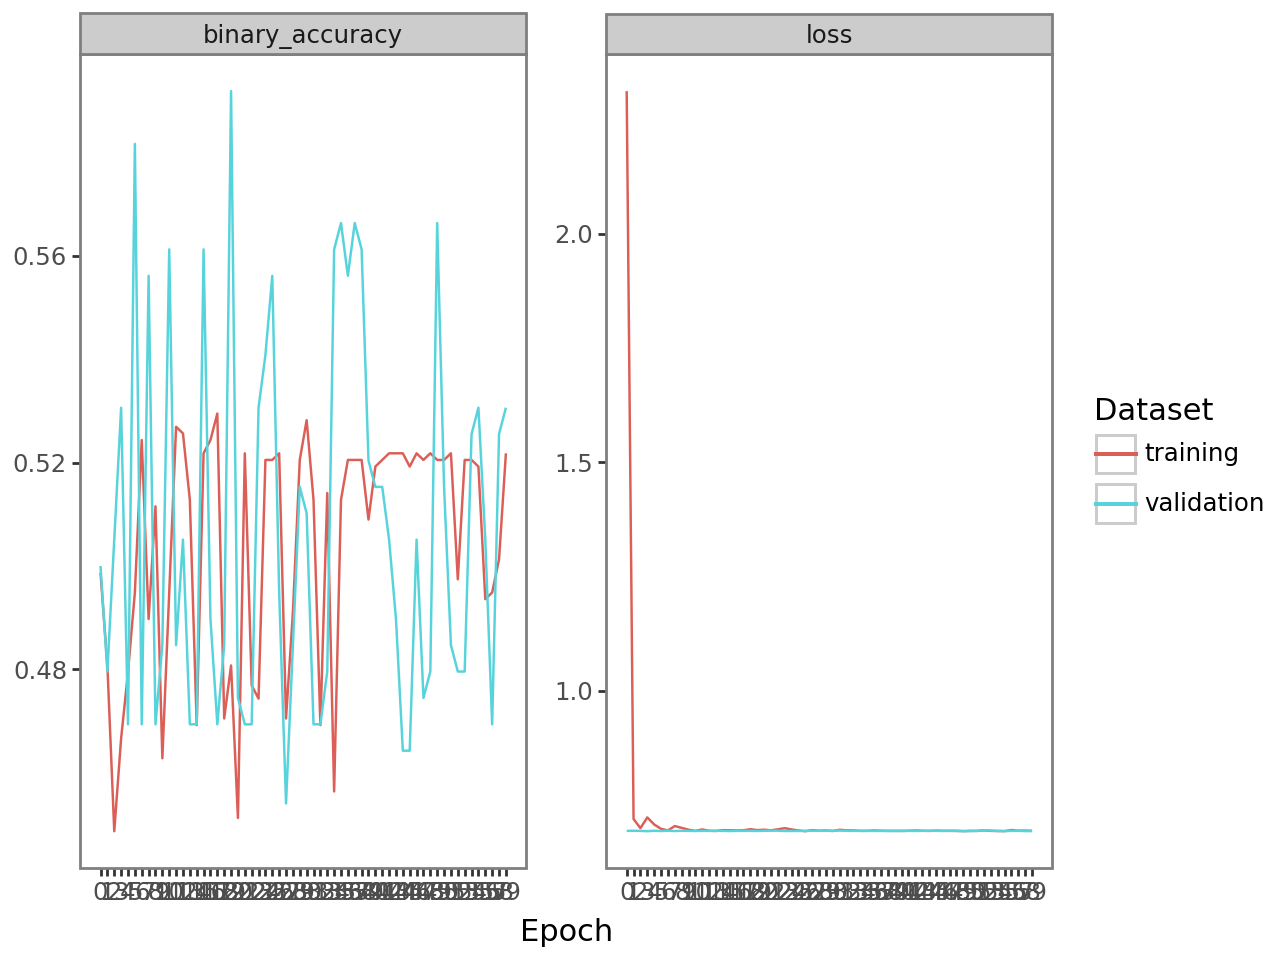

In [ ]:
# function used to plot model accuracy
def plot_fit_history(history):
  df = pd.DataFrame(history.history)
  df['epoch'] = np.arange(len(df))

  # Reshape the dataframe to long format
  df_longer = df.melt(id_vars=['epoch'], var_name="measure", value_name="value")

  # Extract measure name and data type (train or validation)
  df_longer['data_type'] = df_longer['measure'].apply(lambda x: 'validation' if x.startswith('val_') else 'training')
  df_longer['measure'] = df_longer['measure'].apply(lambda x: re.sub('val_', '', x))

  return (ggplot(df_longer, mapping=aes(x="epoch", y="value", color="data_type"))+
   geom_line()+
   scale_x_continuous(breaks=np.arange(0, len(df)))+
   facet_wrap('~measure', scales='free_y')+
   labs(x = "Epoch", y="", color="Dataset")+
   theme_bw()+
   theme(panel_grid=element_blank()))

plot_fit_history(fit_model)

Model accuracy is currently not very high. Both training and testing data remain around 50%. I imagine this is currently because my network does not have neurons and is not learning a lot of patterns (it's just randomly guessing). It could also be that the differences between fatal andnonfatal intersections are not big enough to allow for proper learning (as all intersections have similarities in road features)? To fix this, I will try to add additional convolutional layers and additional nodes to try to coax the model into identifying patterns between images.


---

## Model 2 - More Layers and Nodes

In [ ]:
# image size is 400 x 400; 3 for RGB colors
cnn_input = keras.layers.Input(shape=(400,400,3))

# Augments the inputted image to prevent overfitting. Sticks to augmentations that might appear
# on the screen visually (weather changes) and VERY slight translational movements in case the
# displacement of the camera is too consistent in the training data.
cnn_data_augmentation = keras.layers.Pipeline([
    keras.layers.RandomBrightness((0, 0.1)),
    keras.layers.RandomSaturation(0.1),
    keras.layers.RandomContrast(0.05),
    keras.layers.RandomTranslation(0.01, 0.01),
    keras.layers.RandomZoom(0.03)
])(cnn_input)

# more conv layers for greater pattern recognition
cnn_layer11 = keras.layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), activation='relu')(cnn_data_augmentation)
cnn_layer12 = keras.layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), activation='relu')(cnn_layer11)
cnn_max_pool1 = keras.layers.MaxPool2D(pool_size=(2,2))(cnn_layer12)

# more conv layers for greater pattern recognition
cnn_layer21 = keras.layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), activation='relu')(cnn_max_pool1)
cnn_layer22 = keras.layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), activation='relu')(cnn_layer21)
cnn_max_pool2 = keras.layers.MaxPool2D(pool_size=(2,2))(cnn_layer22)

# more filters for in
cnn_layer31 = keras.layers.Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), activation='relu')(cnn_max_pool2)
cnn_layer32 = keras.layers.Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), activation='relu')(cnn_layer31)
cnn_max_pool3 = keras.layers.MaxPool2D(pool_size=(2,2))(cnn_layer32)

# flattens the max pooling layer for dense layer setup
cnn_flatten = keras.layers.Flatten()(cnn_max_pool3)

# dense layers with descending neuron counts for more precise learning on lower-level features
cnn_dense1 = keras.layers.Dense(100, activation='relu')(cnn_flatten)
cnn_dense2 = keras.layers.Dense(50, activation='relu')(cnn_dense1)

# sigmoid output for probability output
cnn_output = keras.layers.Dense(1, activation='sigmoid')(cnn_dense2)

cnn_model = keras.Model(inputs=cnn_input, outputs=cnn_output)

cnn_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 400, 400, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pipeline_1 (Pipeline)           │ (None, 400, 400, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 398, 398, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 396, 396, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 198, 198, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 196, 196, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 194, 194, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 97, 97, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 95, 95, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 93, 93, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 46, 46, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 270848)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 100)            │    27,084,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,424,017 (104.61 MB)

 Trainable params: 27,424,017 (104.61 MB)

 Non-trainable params: 0 (0.00 B)

# NOTE: RAN OUT OF GPU UNITS HERE SO EVERYTHING FROM HERE ONWARD IS RUNNING ON CPU :((

In [ ]:
cnn_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss="binary_crossentropy",
    metrics=["binary_accuracy"],
)

# implemented early stopping to prevent overfitting (don't anticipate this being an issue though)
early_stopping_callback = keras.callbacks.EarlyStopping(monitor="val_loss", patience = 4)

# Learning Rate Scheduler
# from tensorflow.keras.callbacks import ReduceLROnPlateau
# lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.00001)

fit_model = cnn_model.fit(image_dataset_train, epochs=60, batch_size=64, validation_data=(image_dataset_test))#, callbacks=[early_stopping_callback]) #, lr_scheduler])

Epoch 1/60


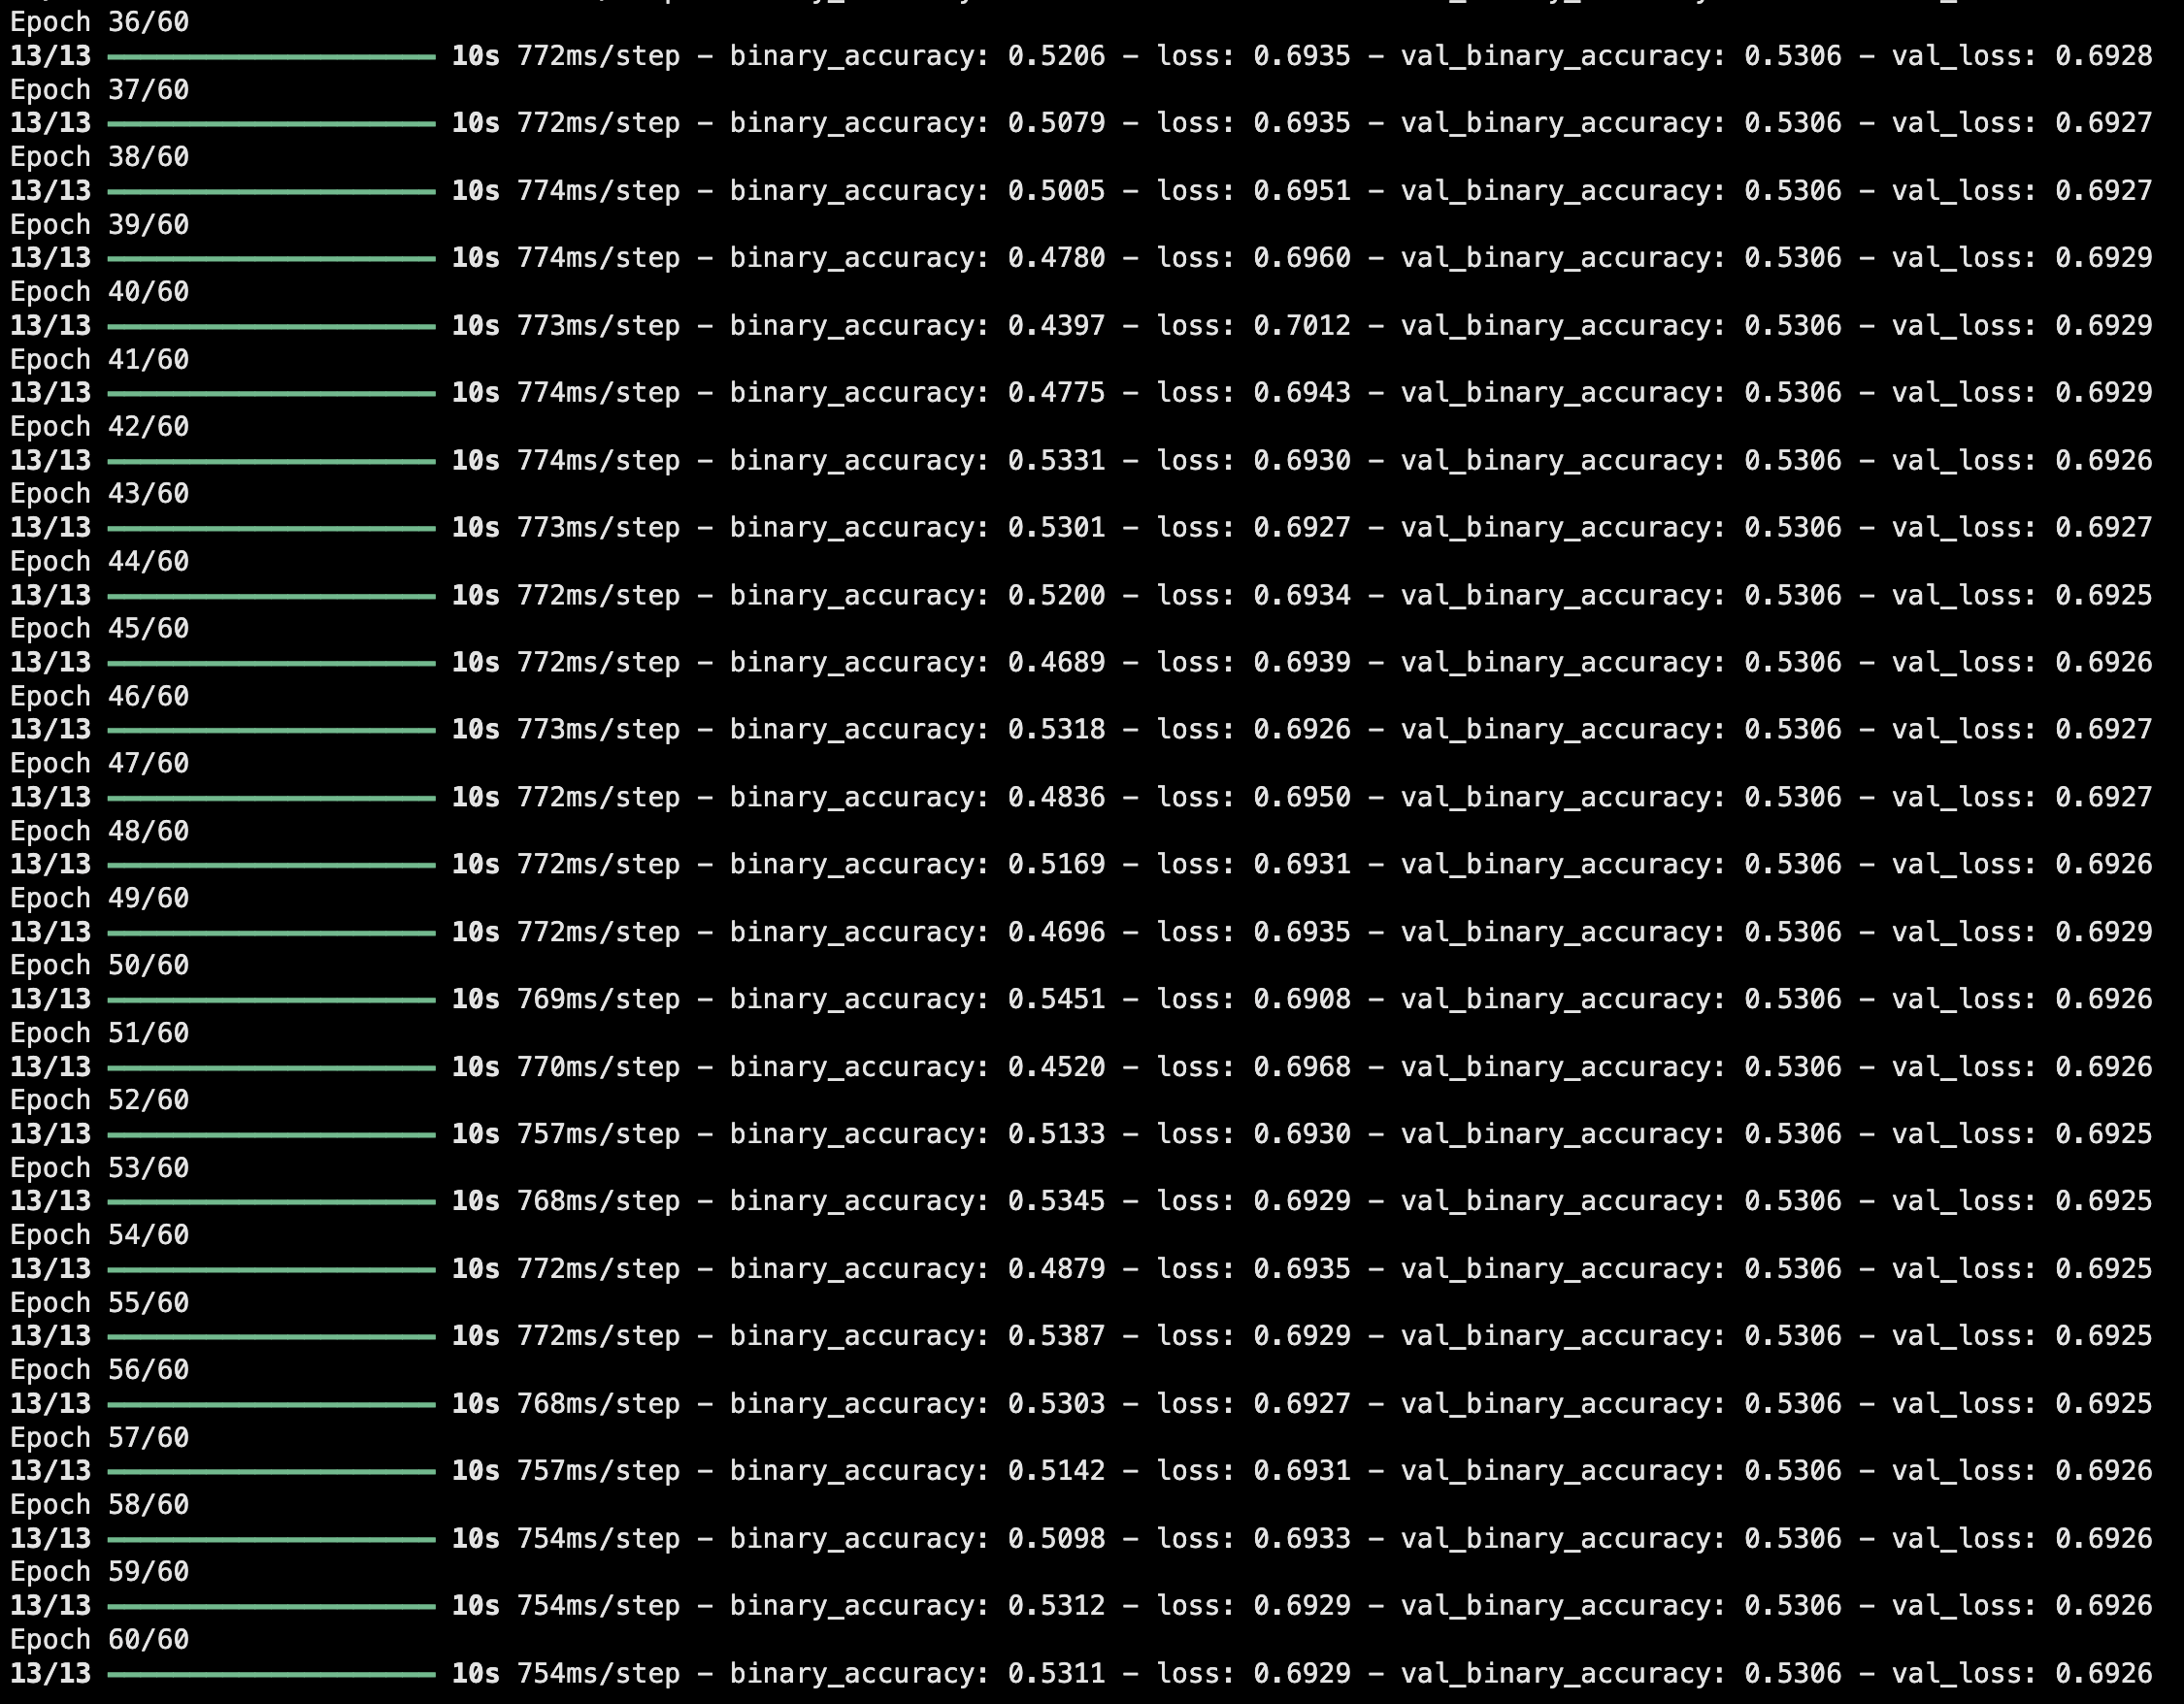

In [ ]:
plot_fit_history(fit_model)

This model performs marginally better, but my accuracy for both testing and training data seems to be settling around 0.53  and my loss for both testing and training data is consistently around 0.69. As a result, I still don't think that my model is learning anything really from my training data. I don't think this is an issue with my model, but more an issue with the lack of discernable differences in the images being used. It could also be that the simplified model only really uses one approach for each intersection (due to the severeReduceSamples method), meaning that the relevant fatal approach might not even be included in the training data. In the future, an attempt to utilize this data could reveal interesting results.

It should be noted here that I have used up 4,000 images from my 10,000 image total (an image limit imposed before I get charged). As a result, I will not be able to test the claims from the paragraph above by increasing the size of my sample without decreasing my ability to run other, model-based tests. Since the focus of this project is (currently) on model structure and not model data, I will be tabling data-based experimentation for now in favor of model-based experimentation.

There are two more experiments I hope to run with my remaining compute units. First, I hope to try transfer learning with  in order to see if a pretrained and well-structure model performs better on my image data. Second, I hope to move towards a multi-modal model that incorporates image data into one of my successful models.


---

## Model 3 - Transfer-Tuned Model

Looking into Image Classifiers on Keras Hub, I have located the following image classification models:
1. CSPNet
2. DeiT
3. DenseNet
4. EfficientNet
5. HGNet2
6. MiT
7. MobileNet
8. MobileNetV5
9. ResNet
10. VGG
11. ViT
12. Xception

From these models, I am looking for models that are clear about their image resolution sizes and utilizes a CNN (or similar structure). The following models seem to fit this requirement:

1. Deit
2. DenseNet
3. ResNet
4. VGG
5. ViT

While I think most of these models can work, I will be utilizing ResNet50 model as it seems to be using a sweet spot of parameters among the model options (~20 million) that I think is likely to avoid overfitting or being excessive to my smaller sample size.

I decided to ultimately rely on transfer-learning as I did want my model to attempt to learn new features from the street view images (which can be very chaotic), but rather, apply the already learned features to the new dataset.

In [ ]:
resNet = keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(400, 400, 3))

resNet_top_flatten = keras.layers.Flatten(name="flatten")(resNet.get_layer('conv5_block3_add').output)
fc1 = keras.layers.Dense(500, activation="relu", name="fc1")(resNet_top_flatten)
fc2 = keras.layers.Dense(500, activation="relu", name="fc2")(fc1)
resNet_output = keras.layers.Dense(1, activation="sigmoid", name="output")(fc2)

resNet.trainable = False
resNet_transfer_learning = keras.Model(inputs=resNet.input, outputs=resNet_output)

resNet_transfer_learning.summary()

In [ ]:
resNet_transfer_learning.compile(
    optimizer=keras.optimizers.Adam(),
    loss="binary_crossentropy",
    metrics=["binary_accuracy"],
)

resNetTL = resNet_transfer_learning.fit(image_dataset_train, epochs=60, batch_size=64, validation_data=(image_dataset_test))

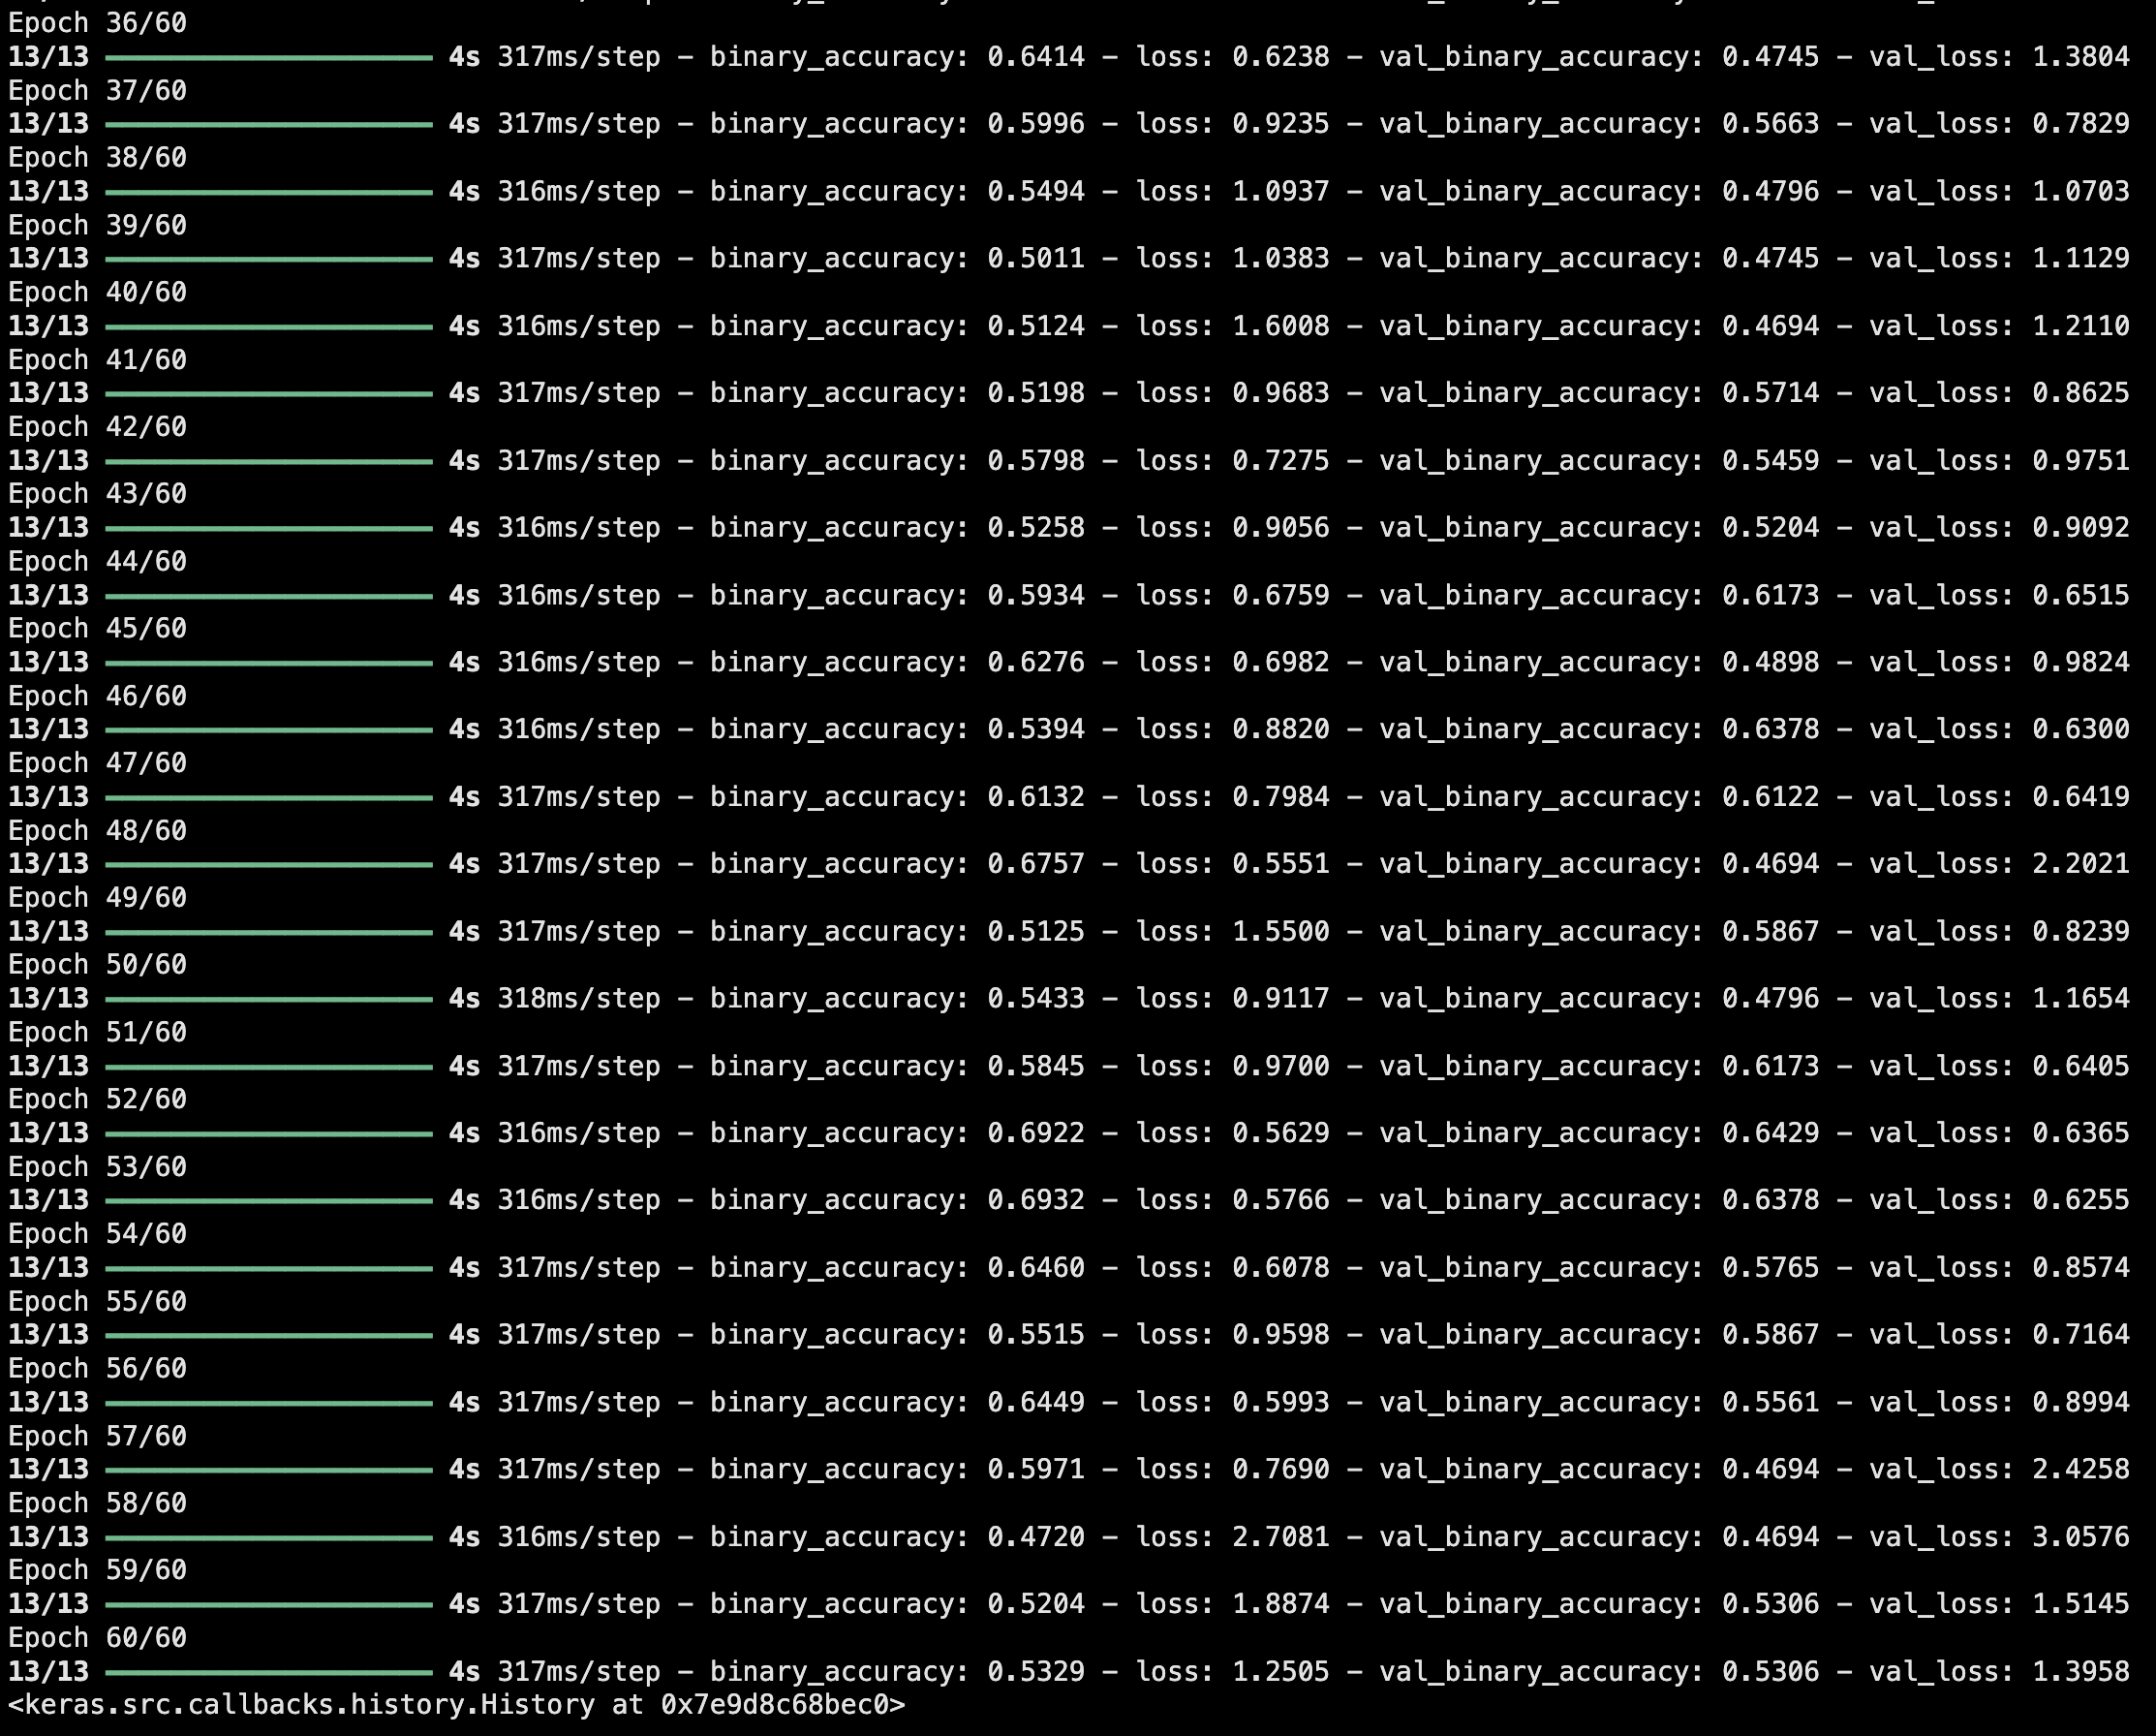

In [ ]:
plot_fit_history(resNetTL)

Ultimately, this network seems to be performing a bit more interestingly than the previous network (in that there was significantly more variation in loss and accuracy). While the previous network was much more consistent and did not seem to be learning anything, this network seems to be much more variable in its accuracy (which makes jumps in the range of 45-70% accurate) and loss values (which stays around 0.5 but occassionally makes jumps to 1.0 or 2.0). I believe the stable accuracy is probably because either my street view images do not correlate strongly with the crash data or because my model is not complex enough to be able to be able to pick up on the cue signs of this correlation.

In [ ]:
# loads needed libraries and climate data store API
# CDSAPI is needed for data, xarray for the .grib file outputs
# and netCDF4 for array-based file outputs (what I will use)
# https://cds.climate.copernicus.eu/how-to-api
%pip install cdsapi xarray netCDF4
import cdsapi
import xarray as xr
CDS_API_Key = userdata.get('CDS_API')

# sets up climate data store as the client
client = cdsapi.Client()

# All below sets up the dataset where retrieval is happening, the data
# being requested, and the target location for downloaded data

# A dataset of hourly climate data
dataset = 'reanalysis-era5-single-levels'


request = {
  'product_type': ['reanalysis'],

  'variable': ["2m_temperature", # temp of air 2m above land/sea in kelvin
               "total_precipitation", # total precipitation (falling water, but not fog) in depth by meters
               "10m_u_component_of_wind",
               "10m_v_component_of_wind"],

  'year': ['2024'],
  'month': ['03'],
  'day': ['01'],
  'time': ['13:00'],
  'area': [],
  'data_format': 'netcdf',
}
target = 'weather_conditions.nc'

# retrieves requested data from a given dataset in the
# climate data store
client.retrieve(dataset, request, target)



In [ ]:
# TODO: identify hotspot areas in WashingtonDC

##Reflection:

The convolutional neural network in this experiment is a neural network that takes in matrices of pixels that represent images. In this case, my model receives a matrix-representation of the pixels of a static street view image. A multi-pixel filter is then utilized and moved across the screen to identify section-to-section patterns (or features) such as brightness differences. This is done by calculating the dot product between the image pixels and the filter weights. After this max pooling layers are utilized to reduce the dimensions of the street view image, allowing larger patterns (i.e. full signs and cars) to be identified in later convultional layers. Finally, these layers are compiled into dense layers which combine the information from the extracted convultional layers to allow for feature learning. After this, a sigmoid function is utilized to provide a probability rating for one of two possible options (in this case, fatal intersection or nonfatal).

In this case, I intended the multiple convultional and max-pooling layers of my model to identify street view features from the ground up. For example, a the first conv2d layer might see circles, the second conv2d layer might see circles and rectangles, and the last conv2d layer might be able to identify the full traffic light. The transfer learning model was implemented to pick up on similar cues.

It was my hope that my model could learn to identify both road features (stop signs, lights, crosswalks, curbs, etc.) and traffic features (pedestrians, bikes, cars, etc.) and combine information from both categories to make judgements on whether an intersection is considered safe.

Ultimately, the models implemented during this project were not able to accurately or consistently identify intersections that were prone to experiencing fatal accidents using street imagery alone.

---

##Notes and future thoughts

This project taught me a lot about the types of data that drive deep learning and how deep learning model accuracy can sometimes be hard to predict. While I was not able to finish this data science project in full, I hope to use this model in the future to address more questions in the about society.